In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

In [9]:
database = "data.sqlite"

conn = sqlite3.connect(database)

train_df = pd.read_sql("select * from new_table_name", con=conn)
train_df.head()

,Unnamed: 0,year,make,model,final_price,mileage,engine,zipcode,engine string
0,1,1997,Chevrolet,Chevrolet Suburban,"$17,000",67000,5700.0,60069,5.7L Vortec V8
1,2,1990,Porsche,Porsche 964 911,"$225,000",1000,3800.0,84790,3.8-Liter Flat-Six
2,3,2003,Toyota,Toyota Pickup,"$24,750",116000,3400.0,90027,3.4-Liter DOHC V6
3,5,1992,Volkswagen,Volkswagen Golf/Rabbit Cabriolet,"$10,750",100000,1800.0,98208,1.8-Liter Inline-Four
4,6,2008,Toyota,Toyota FJ Cruiser,"$32,500",9000,4000.0,57108,4.0-Liter V6


In [10]:
conn.close()

In [11]:
train_df['final_price']=(train_df['final_price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [12]:
train_df = train_df.drop(['model', 'engine string', 'Unnamed: 0', 'zipcode'], axis='columns')
train_df

,year,make,final_price,mileage,engine
0,1997,Chevrolet,17000.0,67000,5700.0
1,1990,Porsche,225000.0,1000,3800.0
2,2003,Toyota,24750.0,116000,3400.0
3,1992,Volkswagen,10750.0,100000,1800.0
4,2008,Toyota,32500.0,9000,4000.0
...,...,...,...,...,...
7100,1983,Jeep,39962.0,24000,4200.0
7101,1997,Ford,24900.0,75000,7300.0
7102,1972,Honda,2400.0,5000,174.0
7103,2005,Ford,17750.0,22000,3900.0


In [13]:
train_df.make.value_counts()

Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
                 ... 
Alpine              1
Nash                1
Bricklin            1
Opel                1
Renault             1
Name: make, Length: 68, dtype: int64

In [14]:
train_df1 = train_df.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'other') if x.name=='make' else x)
train_df1.make.value_counts()

other            1547
Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
Toyota            315
Honda             200
Land Rover        174
Volkswagen        168
Jaguar            163
Jeep              161
Ferrari           150
Pontiac           110
Name: make, dtype: int64

In [15]:
# Convert categorical data to numeric and separate target feature for training data
train_df2 = pd.get_dummies(train_df)
train_df2.head()

,year,final_price,mileage,engine,make_AMC,make_Acura,make_Alfa Romeo,make_Alpine,make_Amphicar,make_Ariel,...,make_Saab,make_Shelby,make_Studebaker,make_Subaru,make_Sunbeam,make_Toyota,make_Triumph,make_Volkswagen,make_Volvo,make_Willys
0,1997,17000.0,67000,5700.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1990,225000.0,1000,3800.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2003,24750.0,116000,3400.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1992,10750.0,100000,1800.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,32500.0,9000,4000.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [16]:
train_X = train_df2.drop(columns='final_price')
train_y = train_df2['final_price']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=42)

In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(f'Model Score: {model.score(X_train_scaled, y_train)}')
print(f'Model Score: {model.score(X_test_scaled, y_test)}')

Model Score: 0.26766515342975683
Model Score: -1.8699450895005813e+23


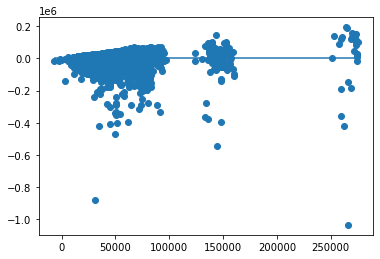

In [20]:
predictions = model.predict(X_train_scaled)
# Plot Residuals
plt.scatter(predictions, predictions - y_train)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [21]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(f"True output: {train_y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y_train[0]}")

x_min = X_train_scaled.min()
x_max = X_train_scaled.max()
y_min_actual = y_train.min()
y_max_actual = y_train.max()

y_min = 101.896225057 + (model.coef_ * x_min)
y_max = 101.896225057 + (model.coef_ * x_max)
print(f"Actual Min Value: {y_min_actual}")
print(f"Calculated Min Value: {y_min}")
print(f"Actual Max Value: {y_max_actual}")
print(f"Calculated Max Value: {y_max}")

# y_min_predicted = model.predict([[x_min]])
# y_max_predicted = model.predict([[x_max]])
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Predicted Min Value: {y_min_predicted}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Predicted Max Value: {y_max_predicted}")

# plt.scatter(X, y, c='blue')
# plt.plot([x_min, x_max], [y_min, y_max], c='red')

Weight coefficients:  [ 1.08379186e+03 -4.53666078e+03  8.70350220e+03 -1.96530209e+16
 -6.40114788e+16 -7.15129349e+16  3.41018366e+16 -1.60481310e+16
 -1.13488075e+16 -6.19905497e+16 -7.74668498e+16 -5.06628174e+16
 -2.59008119e+17 -5.77318425e+16 -1.13488075e+16 -6.19905497e+16
 -9.09457159e+16 -2.59782496e+17 -4.53312722e+16 -2.26912229e+16
 -9.09457159e+16 -2.26912229e+16 -3.00092079e+16 -9.82376665e+16
 -1.19364521e+17 -5.31255998e+16 -2.45229003e+17 -6.69258433e+16
 -1.60481310e+16 -1.35698281e+17 -4.93846575e+16 -5.88260472e+16
 -1.60481310e+16 -1.21412206e+17 -1.20903836e+17 -1.60481310e+16
 -4.38959467e+16 -1.13488075e+16 -1.29721587e+17 -8.59662905e+16
 -5.19090492e+16 -6.49978266e+16 -7.58150534e+16 -4.24115042e+16
 -8.81364309e+16 -4.08725933e+16 -2.51252268e+17 -3.20781780e+16
 -5.88260472e+16 -5.31255998e+16 -1.96530209e+16 -1.60481310e+16
 -1.13488075e+16 -6.78687813e+16 -6.40114788e+16  2.72848411e-12
 -5.31255998e+16 -1.04996685e+17 -3.01469332e+17 -1.13488075e+16
 -3

In [22]:
reg = Lasso(max_iter=10000).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.26804787330373536
Test Score: 0.06990602541123325


In [23]:
reg = Ridge(alpha=100).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.2679359935686624
Test Score: 0.07191953465417744


In [24]:
reg = ElasticNet(alpha=10).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.08950727765164945
Test Score: 0.03896535884460828


In [25]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}\n')
    plt.show()
    y_pred = reg.predict(X_test_scaled)
    print(mean_absolute_error(y_test, y_pred))    

In [26]:
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [27]:
test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)

Model: KNeighborsRegressor
Train score: 0.6052034645832656
Test Score: 0.23028774481921122

21344.75171637591
Model: RandomForestRegressor
Train score: 0.9077038976420624
Test Score: 0.4208723648046665

18518.667192459197
Model: ExtraTreesRegressor
Train score: 0.9932830981738487
Test Score: 0.44610637652255036

18116.381625398615
Model: AdaBoostRegressor
Train score: -3.9322222889221097
Test Score: -2.729906415227875

113990.48609678543
Model: SVR
Train score: -0.08710783142007417
Test Score: -0.0732446822790187

29266.79350581873


In [28]:
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(tf.keras.layers.Dense(units=729, activation="sigmoid", input_dim=71))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=486, activation="relu"))
nn.add(tf.keras.layers.Dense(units=324, activation="relu"))
nn.add(tf.keras.layers.Dense(units=216, activation="relu"))
# Output layer
nn.add(tf.keras.layers.Dense(units=1))
# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 729)               52488     
                                                                 
 dense_1 (Dense)             (None, 486)               354780    
                                                                 
 dense_2 (Dense)             (None, 324)               157788    
                                                                 
 dense_3 (Dense)             (None, 216)               70200     
                                                                 
 dense_4 (Dense)             (None, 1)                 217       
                                                                 
Total params: 635,473
Trainable params: 635,473
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile the model
nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100000)

Epoch 1/100000
167/167 [==============================] - 2s 9ms/step - loss: 3198645504.0000 - mae: 31894.5020
Epoch 2/100000
167/167 [==============================] - 2s 9ms/step - loss: 2708729600.0000 - mae: 29117.8164
Epoch 3/100000
167/167 [==============================] - 1s 9ms/step - loss: 2604698880.0000 - mae: 28220.8867
Epoch 4/100000
167/167 [==============================] - 1s 9ms/step - loss: 2549538816.0000 - mae: 27788.5625
Epoch 5/100000
167/167 [==============================] - 1s 9ms/step - loss: 2507505408.0000 - mae: 27249.1445
Epoch 6/100000
167/167 [==============================] - 1s 9ms/step - loss: 2487309312.0000 - mae: 27146.2559
Epoch 7/100000
167/167 [==============================] - 1s 8ms/step - loss: 2473211904.0000 - mae: 26771.0215
Epoch 8/100000
167/167 [==============================] - 1s 8ms/step - loss: 2445581312.0000 - mae: 26560.1270
Epoch 9/100000
167/167 [==============================] - 1s 9ms/step - loss: 2427745024.0000 - mae: 265

KeyboardInterrupt: 

In [ ]:
#Note: 200-100-50-25-1
#7k Epochs - MAE 28117